# 3C. Data Modeling: Clustering
<hr>

We will now assess the results of the zipcode -> neighborhood clustering conversion, running the same models as in ```3A. Data Modeling: Airbnb Listings``` and comparing the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pylab
import scipy.stats as stats
import math
%matplotlib inline

In [2]:
# helper function for plotting residual plots
def plot_residual(ax1, ax2, ax3, y_pred, y_real, line_label, title):
    ax1.scatter(y_pred, 
                y_real, 
                color='blue',
                alpha=0.6,
                label=line_label)
    ax1.set_xlabel('Predicted Y') 
    ax1.set_ylabel('Real Y')
    ax1.legend(loc='best')
    ax1.set_title(title)

    ax2.scatter(y_pred,
                y_real - y_pred, 
                color='green',
                marker='x',
                alpha=0.6,
                label='Residual')
    ax2.set_xlabel('Predicted Y')
    ax2.set_ylabel('Residual')
    
    ax2.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')

    ax2.legend(loc='best')
    ax2.set_title('Residual Plot')
    
    ax3.hist(y_real - y_pred, bins=30, color='green', alpha=0.7)
    ax3.set_title('Histogram of residual values')
    
    return ax1, ax2, ax3

In [3]:
class model:
    
    def __init__(self, model):
        self.model = model
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.y_pred_train = None
        self.y_pred_test = None
        self.train_score = None
        self.test_score = None
        self.train_score_log = None
        self.test_score_log = None
    
    def data_split(self, x, y, test_size):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size)
    
    def score_reg(self):
        return self.train_score, self.test_score
    
    def score_log(self):
        self.train_score_log = metrics.r2_score(np.exp(self.y_train), np.exp(self.y_pred_train))
        self.test_score_log = metrics.r2_score(np.exp(self.y_test), np.exp(self.y_pred_test))
        return self.train_score_log, self.test_score_log
    
    def data_frame_convert(self):
        df_train = pd.DataFrame({'y_pred': self.y_pred_train, 'y_real': self.y_train})
        df_test = pd.DataFrame({'y_pred_test': self.y_pred_test, 'y_real_test': self.y_test})
        return self.train_score, self.test_score, df_train, df_test

    def data_frame_convert_log(self):
        df_train = pd.DataFrame({'y_pred': np.exp(self.y_pred_train), 'y_real': np.exp(self.y_train)})
        df_test = pd.DataFrame({'y_pred_test': np.exp(self.y_pred_test), 'y_real_test': np.exp(self.y_test)})
        return self.train_score_log, self.test_score_log, df_train, df_test
    
    def fit_model(self, x, y, test_size):
        self.data_split(x, y, test_size)
        self.model = self.model.fit(self.x_train, self.y_train)
        self.train_score = self.model.score(self.x_train, self.y_train)
        self.test_score = self.model.score(self.x_test, self.y_test)
        self.y_pred_train = self.model.predict(self.x_train)
        self.y_pred_test = self.model.predict(self.x_test)
    
def model_iterations(n, x, y, model_arg, log_bool=False):
    new_model = model(model_arg)
    training_scores = [None]*n
    testing_scores = [None]*n

    for i in range(n):
        new_model.fit_model(x, y, 0.3)
        training_scores[i], testing_scores[i] = new_model.score_reg() if not log_bool else new_model.score_log()

    print 'Mean Train Score:', np.mean(training_scores)
    print 'Mean Test Score:', np.mean(testing_scores)
    return new_model

In [4]:
# read in neighborhood dataset
data = pd.read_csv('../datasets/listings_neighborhood_clean.csv')

In [5]:
# split into x and y (note that we do not include id and host_id as predictors)
x = data.iloc[:, 2:-2]
y = data.iloc[:, -2]
y_log = data.iloc[:, -1]

## Ridge & Lasso Regression

### Ridge Regression with Untransformed Response

In [6]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(1, x, y, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5))

Mean Train Score: 0.317389383417
Mean Test Score: 0.287039215886


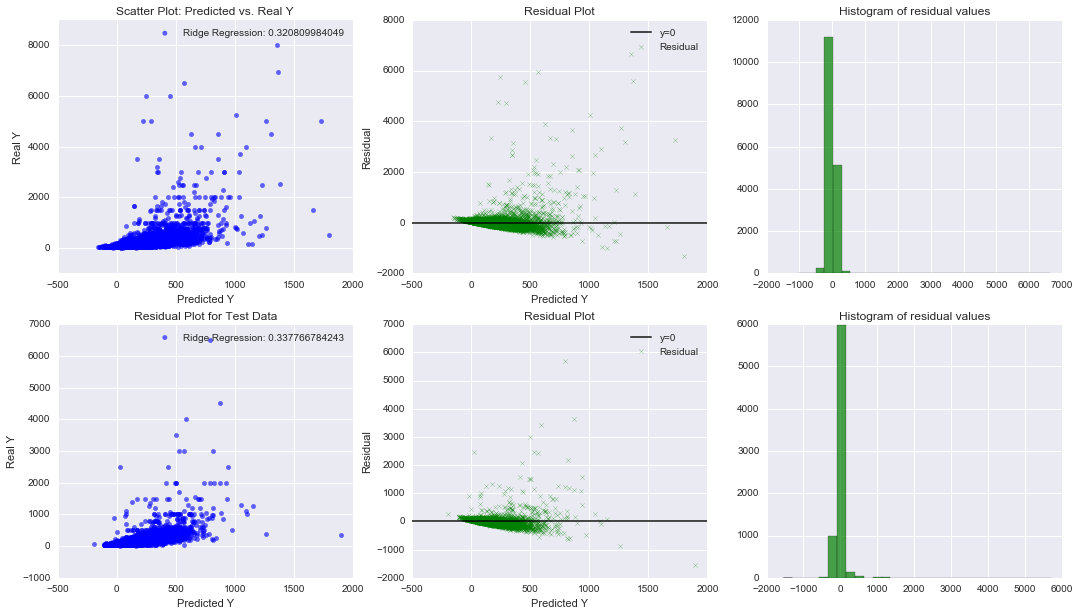

In [29]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

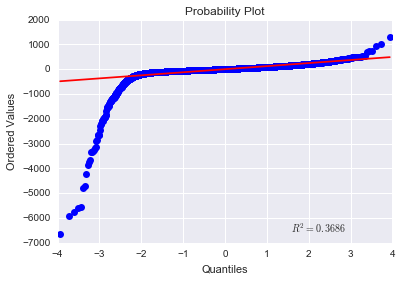

In [30]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Ridge Regression with Log-Transformed Response

In [31]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(5, x, y_log, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5), True)

Mean Train Score: 0.355490988957
Mean Test Score: 0.361796683246


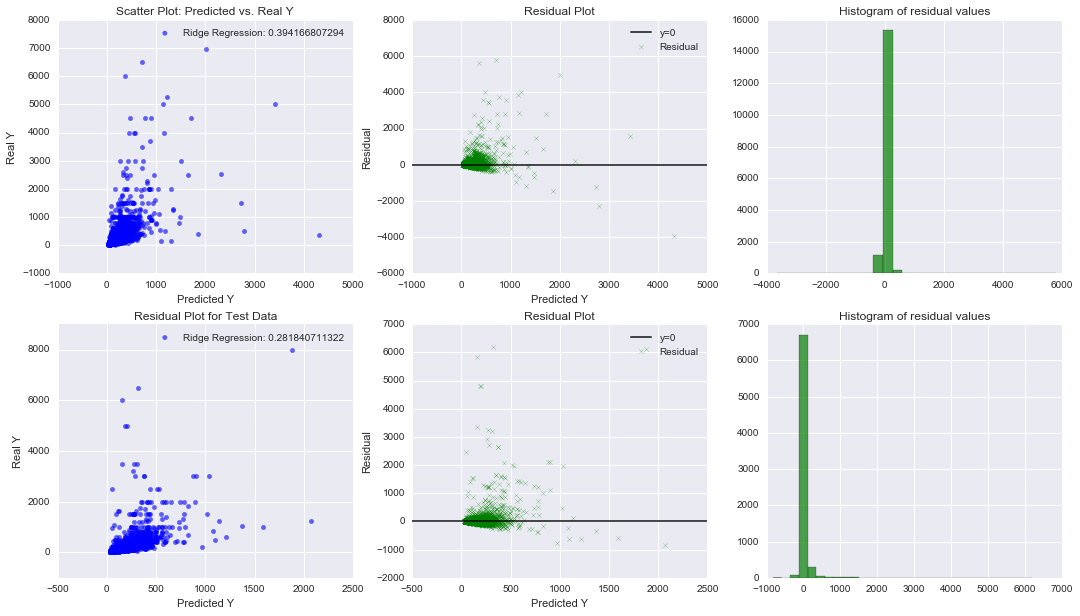

In [32]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

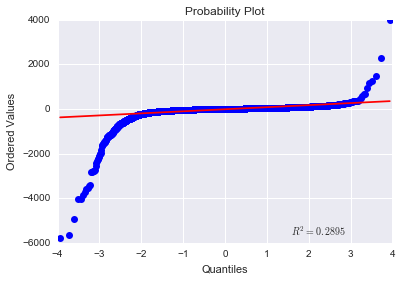

In [33]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Lasso Regression with Untransformed Response

In [10]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y, LassoCV(alphas=reg_params, fit_intercept=True, cv=5))

Mean Train Score: 0.305523648264
Mean Test Score: 0.313385158838


### Lasso Regression with Log-Transformed Response

In [37]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y_log, LassoCV(alphas=reg_params, fit_intercept=True, cv=5), True)

Mean Train Score: 0.362542038651
Mean Test Score: 0.340433970597


## Analysis

Overall we see that clustering by neighborhood performs very similarly to the original dataset with zipcodes. We will next try looking at Median Absolute Error.

## Median Absolute Error

In [13]:
def median_absolute_errors(x, y, log_bool=None):
    reg_params = 10.**np.linspace(-10, 5, 10)
    models = [ linear_model.Ridge(), RidgeCV(alphas=reg_params, cv=5), linear_model.Lasso(), LassoCV(alphas=reg_params, cv=5), linear_model.ElasticNet(), linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
    model_labels = np.array(['Ridge', 'RidgeCV', 'Lasso', 'LassoCV', 'ElasticNet', 'BayesRidge', 'OMP'])
    model_errors = np.array([])

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=15)

    for model in models:
        model.fit(X_train, y_train)
        if not log_bool:
            model_err = metrics.median_absolute_error((y_test), model.predict(X_test))
            model_errors = np.append(model_errors, model_err)
        else:
            model_err = metrics.median_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))
            model_errors = np.append(model_errors, model_err)
    
    model_position = np.arange(model_errors.shape[0])
    models_sorted = np.argsort(model_errors)
    for i, model in enumerate(model_labels):
        print 'Model {} Results: {}'.format(model_labels[i], model_errors[i])

    plt.figure(figsize=(10,8))
    plt.bar(model_position, model_errors[models_sorted], align='center')
    plt.xticks(model_position, model_labels[models_sorted])
    plt.xlabel('Estimator')
    plt.ylabel('Median Absolute Error')
    plt.show()

### Median Absolute Error Untransformed Response


Model Ridge Results: 45.0733616865
Model RidgeCV Results: 44.041747509
Model Lasso Results: 41.1483774137
Model LassoCV Results: 41.1483774137
Model ElasticNet Results: 44.4211434345
Model BayesRidge Results: 44.8814025582
Model OMP Results: 44.1673181849


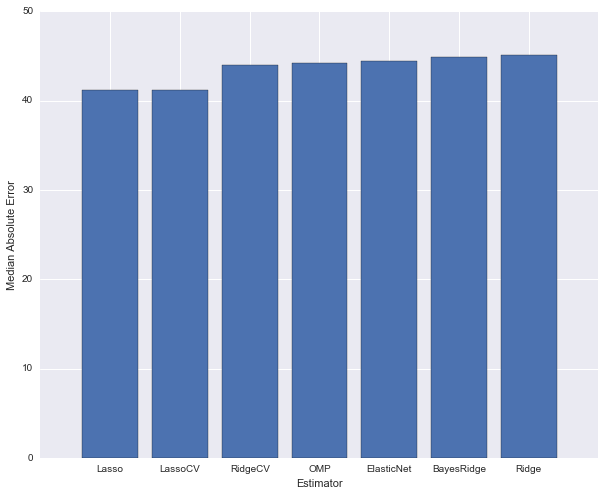

In [14]:
median_absolute_errors(x, y)

### Median Absolute Error Log-Transformed Response

Model Ridge Results: 25.3664157775
Model RidgeCV Results: 25.3664157775
Model Lasso Results: 53.9575620514
Model LassoCV Results: 25.3705859359
Model ElasticNet Results: 53.9575620514
Model BayesRidge Results: 25.3482809254
Model OMP Results: 27.7305304401


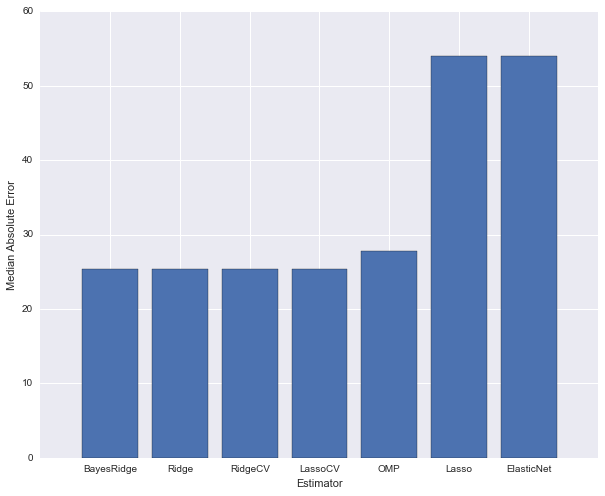

In [15]:
median_absolute_errors(x, y_log, True)

## Single Listing House Data

In [16]:
data_single = data[data['beds'] == min(data['beds'])]

# split into x_1 and y_1 (note that we do not include id and host_id as predictors)
x_1 = data_single.iloc[:, 2:-2]
y_1 = data_single.iloc[:, -2]
y_1_log = data_single.iloc[:, -1]

Model Ridge Results: 25.913234694
Model RidgeCV Results: 25.913234694
Model Lasso Results: 26.1649614946
Model LassoCV Results: 25.9530509914
Model ElasticNet Results: 36.1908957651
Model BayesRidge Results: 25.5724623328
Model OMP Results: 26.2812380006


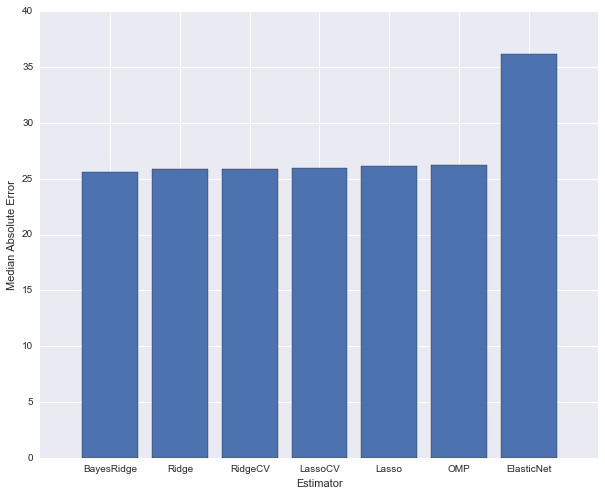

In [17]:
median_absolute_errors(x_1, y_1)

Model Ridge Results: 19.9339124308
Model RidgeCV Results: 19.9339124308
Model Lasso Results: 39.946048994
Model LassoCV Results: 19.9034017465
Model ElasticNet Results: 39.946048994
Model BayesRidge Results: 19.9287597433
Model OMP Results: 22.2644248675


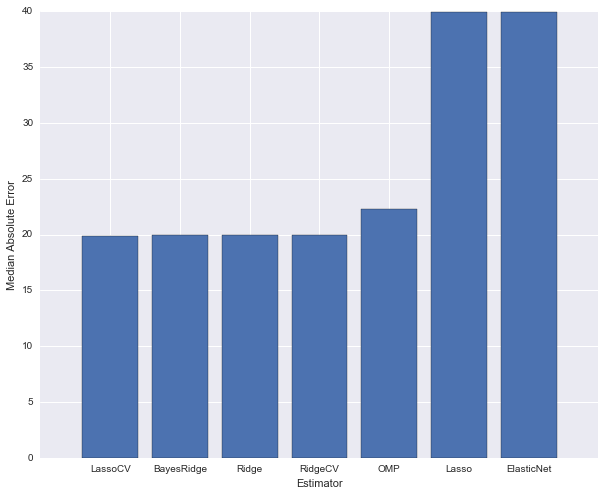

In [18]:
median_absolute_errors(x_1, y_1_log, True)

## Analysis

For both the listing data and single house listing data, we see that clustering by neighborhoods performs very similarly. We can speculate that perhaps the model benefitted from the granularity of segmenting by zipcode as versed to grouping them into overlapping neighborhoods.